<a href="https://colab.research.google.com/github/gupta24789/multiclass-classification/blob/main/bow_tfidf_ngram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install wordcloud

In [125]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Utilities

In [40]:
def process_text(tweet):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

## Load Read Data

In [41]:
train_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/multiclass-classification/main/data/train.txt", header = None, sep=';')
val_df = pd.read_csv("https://raw.githubusercontent.com/gupta24789/multiclass-classification/main/data/val.txt",header = None, sep=';')
train_df.columns = ['complaints','label']
val_df.columns = ['complaints','label']
train_df['processed_complaints'] = train_df.complaints.apply(lambda x: process_text(x))
val_df['processed_complaints'] = val_df.complaints.apply(lambda x: process_text(x))

In [42]:
print(train_df.label.value_counts())

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64


In [43]:
print(val_df.label.value_counts())

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64


## Most common words

In [57]:
stopwords = set(STOPWORDS)

In [58]:
train_df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

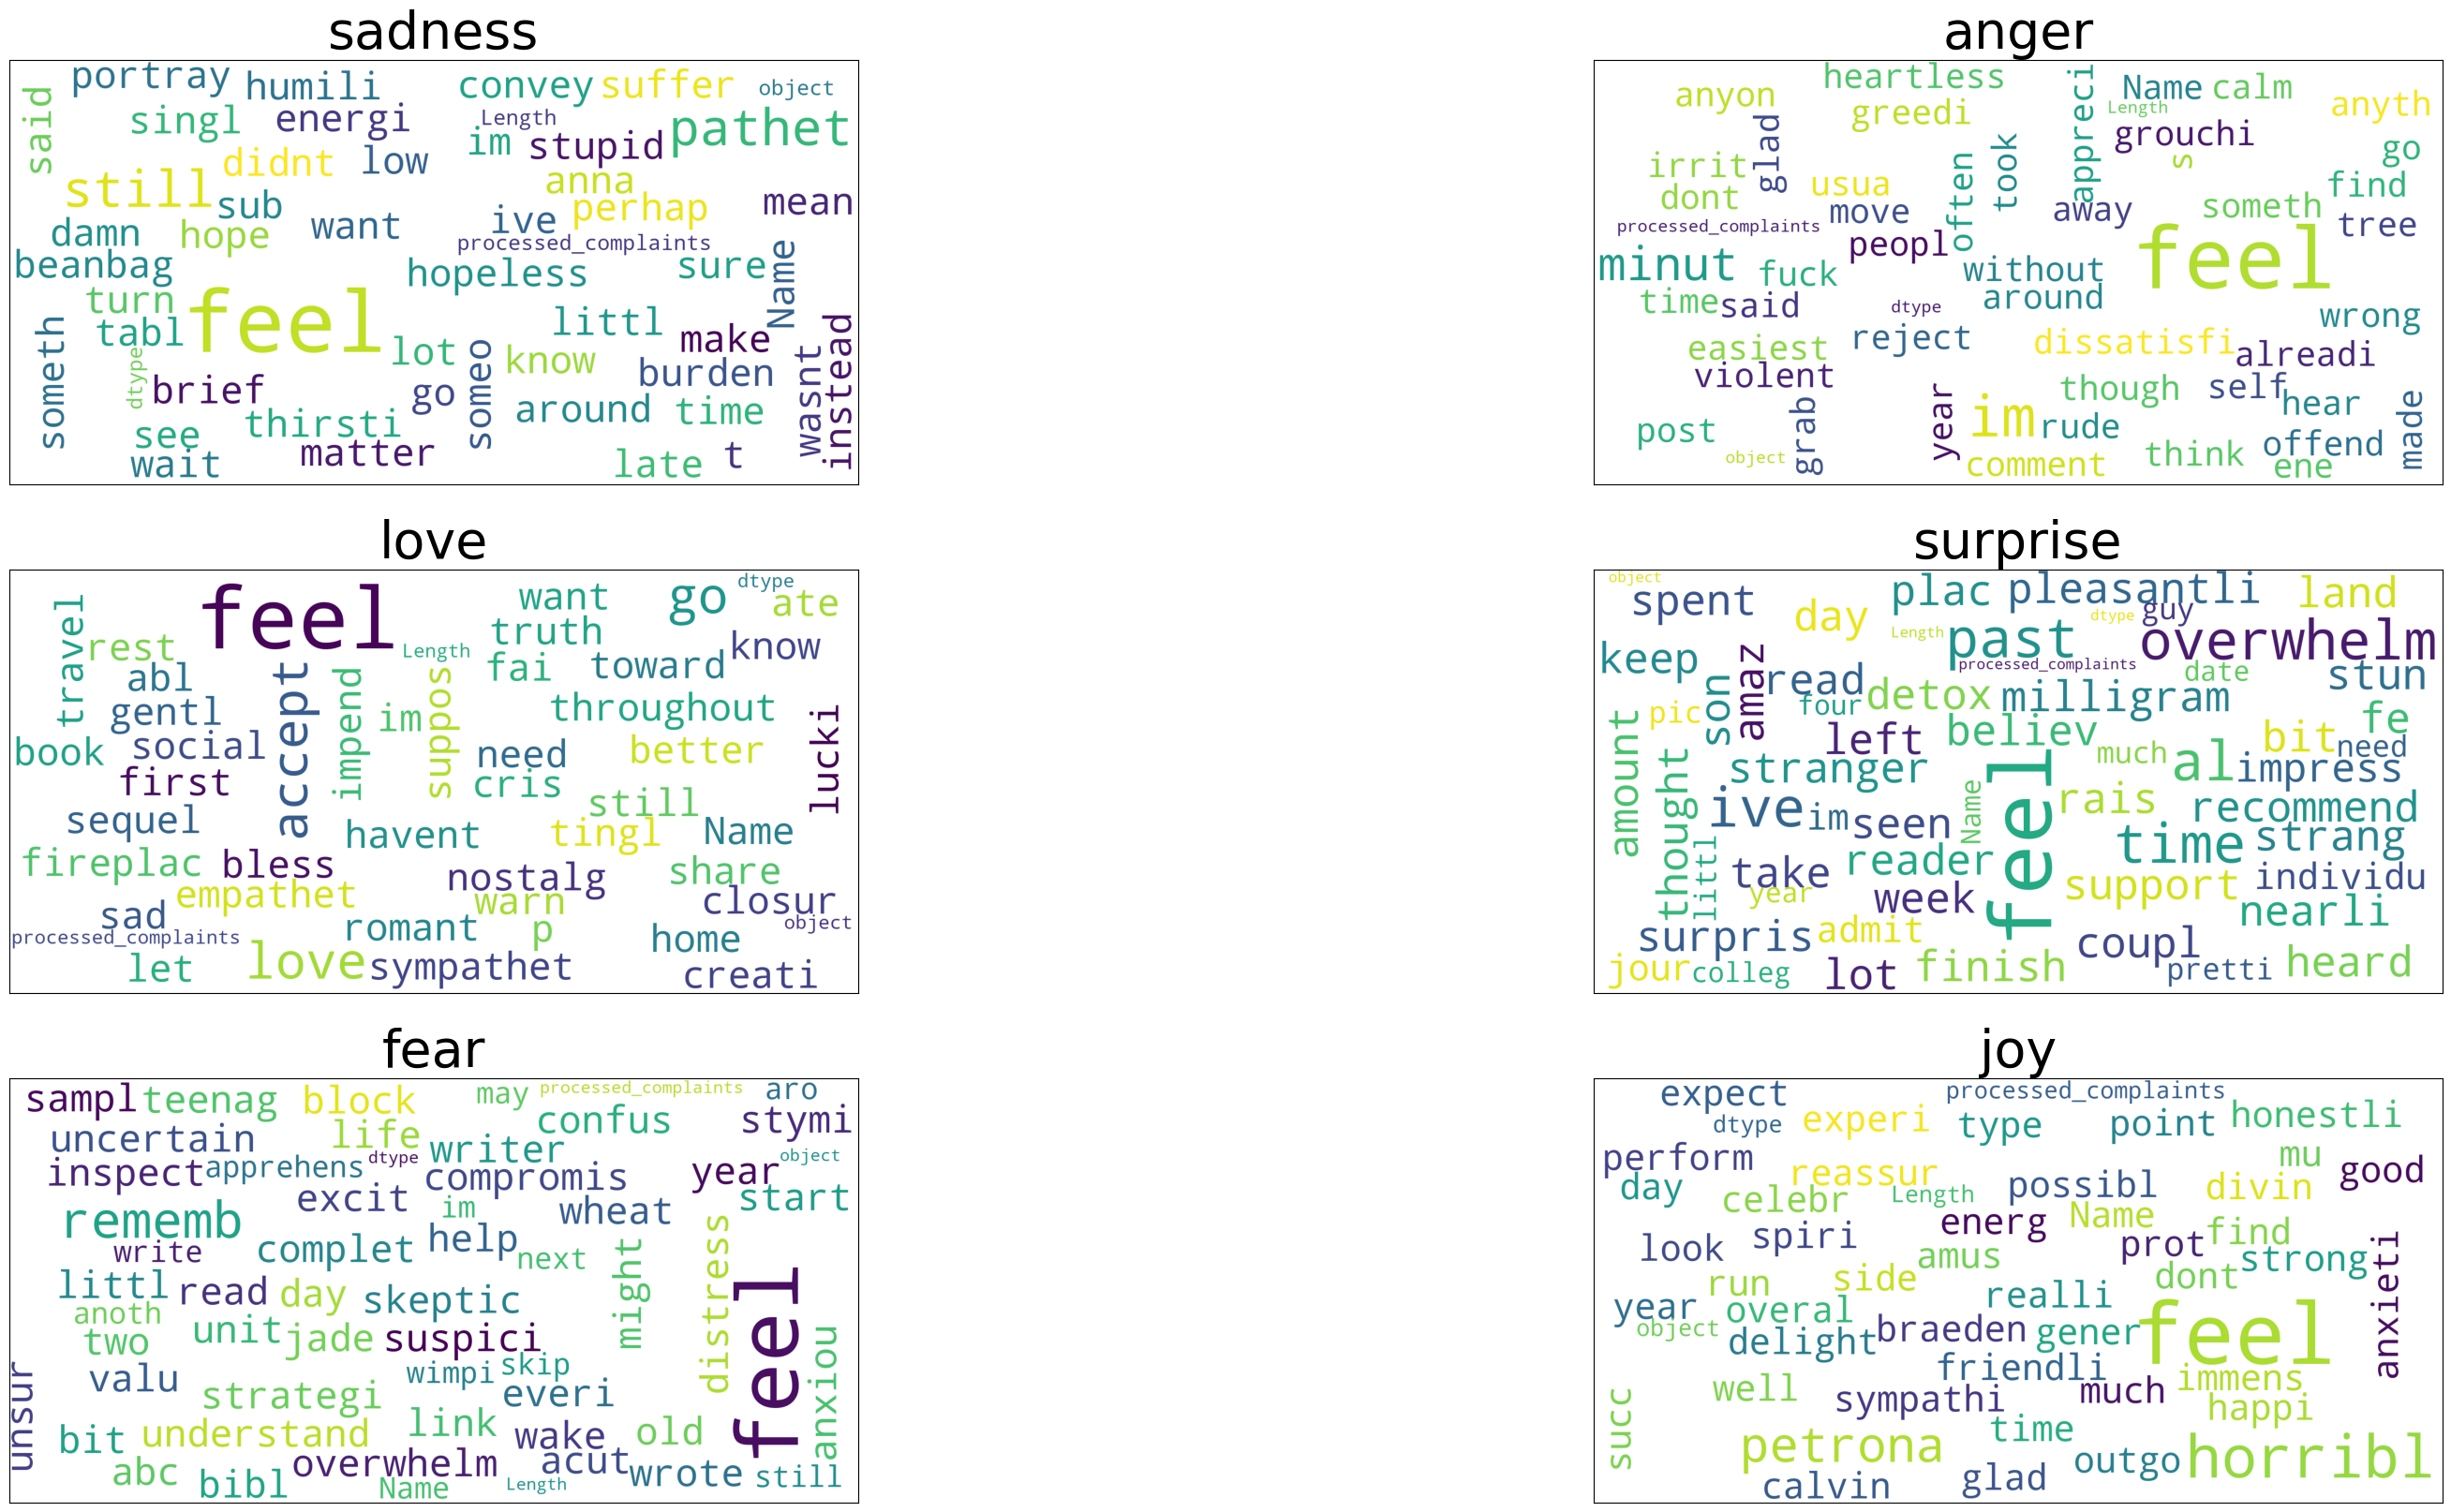

<Figure size 640x480 with 0 Axes>

In [59]:
plt.figure(figsize=(40,20))

for index, col in enumerate(train_df['label'].unique()):
    plt.subplot(3,2, index+1)
    # print(col)
    df1 = train_df[train_df['label']==col].copy()
    data = df1['processed_complaints']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.show()
plt.tight_layout()

In [68]:
label2idx = {w:i for i, w in enumerate(train_df.label.unique().tolist())}
idx2label = {i:w for w,i in label2idx.items()}

In [74]:
train_df['label_encode'] = train_df['label'].apply(lambda x: label2idx[x])
val_df['label_encode'] = val_df['label'].apply(lambda x: label2idx[x])

In [75]:
train_df.head(3)

,complaints,label,processed_complaints,label_encode
0,i didnt feel humiliated,sadness,"[didnt, feel, humili]",0
1,i can go from feeling so hopeless to so damned...,sadness,"[go, feel, hopeless, damn, hope, around, someo...",0
2,im grabbing a minute to post i feel greedy wrong,anger,"[im, grab, minut, post, feel, greedi, wrong]",1


In [80]:
X_train = train_df.processed_complaints.str.join(" ").tolist()
y_train = train_df.label_encode.tolist()

X_val = val_df.processed_complaints.str.join(" ").tolist()
y_val = val_df.label_encode.tolist()

## BOW

In [100]:
## unigram - Logistic
clf = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase=True, ngram_range = (1,1))),
    ('logistic', LogisticRegression())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.89      0.91      0.90       550
       anger       0.84      0.84      0.84       275
        love       0.78      0.69      0.73       178
    surprise       0.73      0.74      0.74        81
        fear       0.81      0.81      0.81       212
         joy       0.87      0.88      0.88       704

    accuracy                           0.85      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.85      0.85      0.85      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
## unigram - Random Forest
clf = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase=True, ngram_range = (1,1))),
    ('rf', RandomForestClassifier())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.89      0.89      0.89       550
       anger       0.80      0.89      0.85       275
        love       0.74      0.72      0.73       178
    surprise       0.71      0.79      0.75        81
        fear       0.79      0.80      0.80       212
         joy       0.90      0.85      0.87       704

    accuracy                           0.85      2000
   macro avg       0.81      0.82      0.81      2000
weighted avg       0.85      0.85      0.85      2000



In [102]:
## bigram - Logistic
clf = Pipeline([
    ('count_vectorizer', CountVectorizer(lowercase=True, ngram_range = (1,2))),
    ('logistic', LogisticRegression())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.90      0.93      0.91       550
       anger       0.89      0.88      0.89       275
        love       0.82      0.74      0.78       178
    surprise       0.77      0.70      0.74        81
        fear       0.87      0.79      0.83       212
         joy       0.88      0.92      0.90       704

    accuracy                           0.88      2000
   macro avg       0.86      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## TFIDF

In [104]:
## unigram - Logistic
clf = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase=True, ngram_range = (1,1))),
    ('logistic', LogisticRegression())
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.85      0.92      0.88       550
       anger       0.86      0.77      0.81       275
        love       0.84      0.61      0.71       178
    surprise       0.86      0.59      0.70        81
        fear       0.82      0.76      0.79       212
         joy       0.83      0.92      0.87       704

    accuracy                           0.84      2000
   macro avg       0.84      0.76      0.79      2000
weighted avg       0.84      0.84      0.84      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [132]:
## unigram - Logistic without class weight
clf = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase=True, ngram_range = (1,2))),
    ('logistic', LogisticRegression(random_state = 42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.84      0.92      0.88       550
       anger       0.90      0.80      0.85       275
        love       0.84      0.61      0.71       178
    surprise       0.84      0.53      0.65        81
        fear       0.87      0.72      0.79       212
         joy       0.83      0.94      0.88       704

    accuracy                           0.85      2000
   macro avg       0.85      0.75      0.79      2000
weighted avg       0.85      0.85      0.84      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Define Class weight

In [139]:
train_df.label_encode.value_counts()

5    5362
0    4666
1    2159
4    1937
2    1304
3     572
Name: label_encode, dtype: int64

In [135]:
np.bincount(y_train)

array([4666, 2159, 1304,  572, 1937, 5362])

In [137]:
n_samples = len(y_train)
n_classes = len(label2idx)
class_weight = dict(enumerate(n_samples / (n_classes * np.bincount(y_train))))
print(class_weight)

{0: 0.5715102157451064, 1: 1.2351397251814111, 2: 2.044989775051125, 3: 4.662004662004662, 4: 1.3766993632765445, 5: 0.49732686808404825}


In [138]:
## unigram - Logistic without class weight
clf = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase=True, ngram_range = (1,2))),
    ('logistic', LogisticRegression(random_state = 42, class_weight= class_weight))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names = list(idx2label.values())))

              precision    recall  f1-score   support

     sadness       0.93      0.89      0.91       550
       anger       0.87      0.91      0.89       275
        love       0.69      0.86      0.77       178
    surprise       0.66      0.90      0.76        81
        fear       0.85      0.82      0.83       212
         joy       0.93      0.85      0.89       704

    accuracy                           0.87      2000
   macro avg       0.82      0.87      0.84      2000
weighted avg       0.88      0.87      0.87      2000



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Predict

In [140]:
input_text = 'i hate this movie'
clean_input_text = " ".join(process_text(input_text))
pred = clf.predict([clean_input_text])[0]
idx2label[pred]

'anger'

In [141]:
input_text = 'i love this movie'
clean_input_text = " ".join(process_text(input_text))
pred = clf.predict([clean_input_text])[0]
idx2label[pred]

'love'

In [116]:
# ## Save model
# import pickle
# pickle.dump(classifier, open('model.pkl', 'wb'))